# Credit Card Default Prediction
**Author:** Mahipal Mali

**Project summary:** Predict whether a credit card customer will default on their loan. This notebook contains dataset overview, EDA, preprocessing, model training (Logistic Regression & Random Forest), evaluation, final model selection, and inference instructions.

---

## 1 — Setup & Imports

Minimal imports and constants.

In [15]:
# Setup and imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay
)

import joblib

# plotting defaults
%matplotlib inline
sns.set(style="whitegrid")

# reproducibility
RANDOM_STATE = 42


## 2 — Load Data
Load the dataset. If the file path differs, update `path` accordingly.

In [16]:
# Load raw CSV (adjust path if needed)
path = "https://github.com/YBIFoundation/Dataset/raw/3474d607bd2bca1aa1a54cf44b99df4ce8ba2073/Credit%20Default.csv"  # ensure this file exists in this path in Colab/Notebook environment
df = pd.read_csv(path)

# quick overview
print("Rows, columns:", df.shape)
df.head()

Rows, columns: (2000, 5)


,Income,Age,Loan,Loan to Income,Default
0,66155.92510,59.017015,8106.532131,0.122537,0
1,34415.15397,48.117153,6564.745018,0.190752,0
2,57317.17006,63.108049,8020.953296,0.139940,0
3,42709.53420,45.751972,6103.642260,0.142911,0
4,66952.68885,18.584336,8770.099235,0.130990,1


## 3 — Dataset Description
- `Income`: Customer annual income
- `Age`: Customer age
- `Loan`: Loan amount
- `Loan to Income`: Loan / Income ratio
- `Default`: Target (0 = No Default, 1 = Default)

## 4 — Basic Info & Types

In [17]:
# info, dtypes, missing values
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Income          2000 non-null   float64
 1   Age             2000 non-null   float64
 2   Loan            2000 non-null   float64
 3   Loan to Income  2000 non-null   float64
 4   Default         2000 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 78.3 KB
None

Missing values per column:
Income            0
Age               0
Loan              0
Loan to Income    0
Default           0
dtype: int64


## 5 — Statistical Summary

In [18]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Income,2000.0,45331.600018,14326.327119,20014.489470,32796.459720,45789.117310,57791.281670,69995.685580
Age,2000.0,40.927143,13.262450,18.055189,29.062492,41.382673,52.596993,63.971796
Loan,2000.0,4444.369695,3045.410024,1.377630,1939.708847,3974.719418,6432.410625,13766.051240
Loan to Income,2000.0,0.098403,0.057620,0.000049,0.047903,0.099437,0.147585,0.199938
Default,2000.0,0.141500,0.348624,0.000000,0.000000,0.000000,0.000000,1.000000


## 6 — Target Distribution

         count
Default       
0         1717
1          283

Proportion:
         proportion
Default            
0            0.8585
1            0.1415


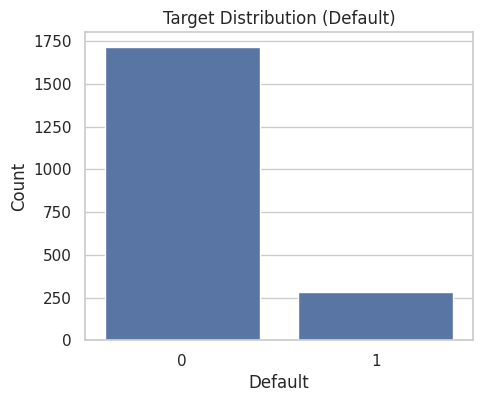

In [19]:
# target counts and proportion
print(df['Default'].value_counts().to_frame('count'))
print('\nProportion:')
print(df['Default'].value_counts(normalize=True).to_frame('proportion'))

plt.figure(figsize=(5,4))
sns.countplot(x='Default', data=df)
plt.title('Target Distribution (Default)')
plt.xlabel('Default')
plt.ylabel('Count')
plt.show()

## 7 — Histograms & Boxplots

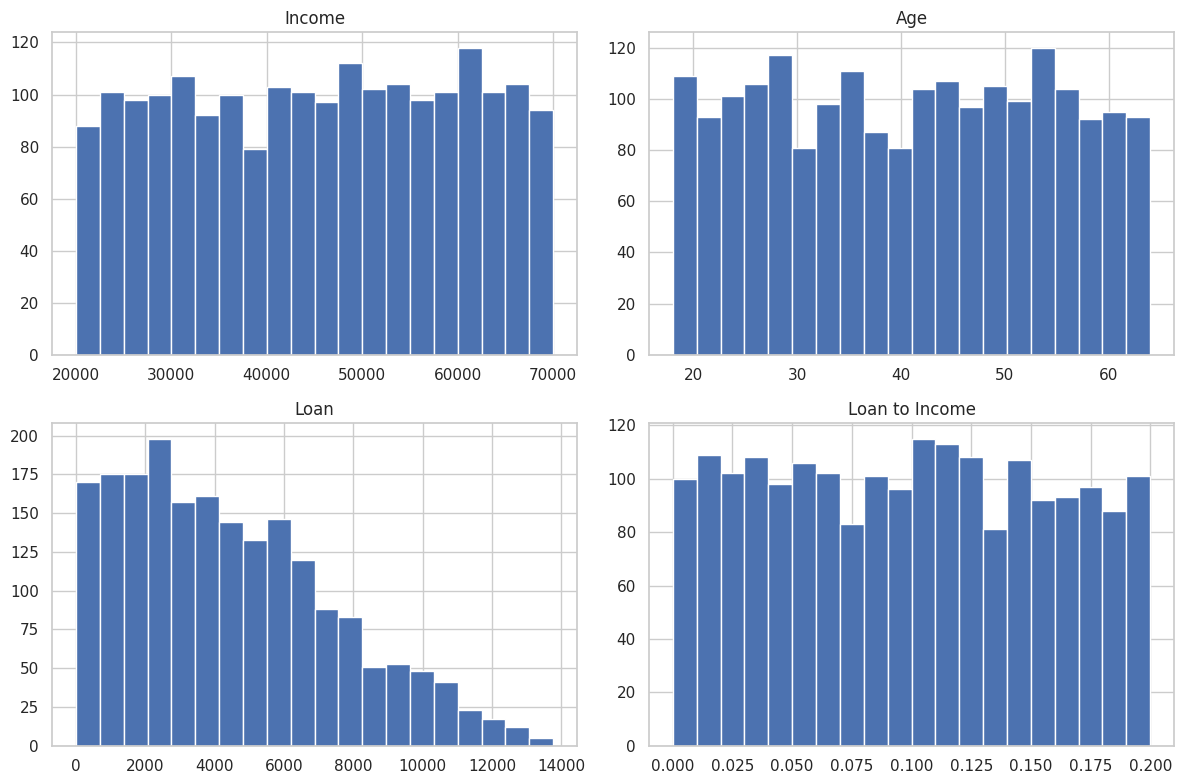

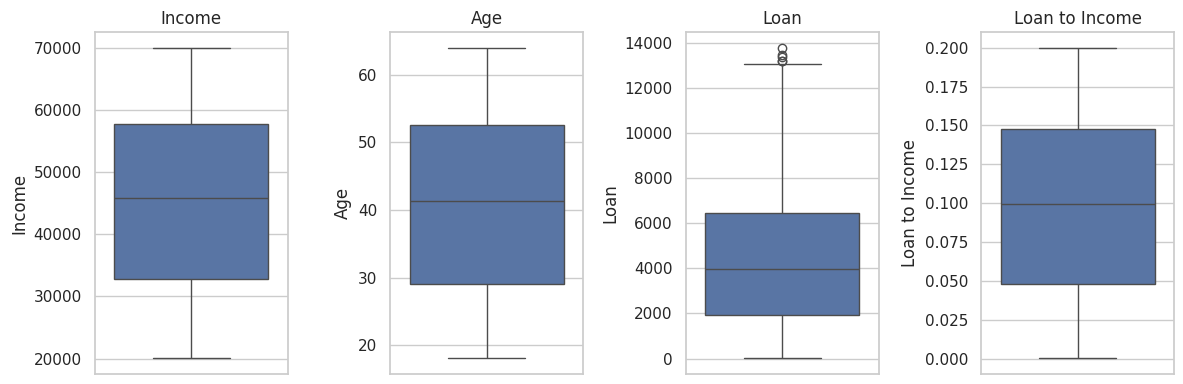

In [20]:
# Histograms and boxplots for numeric features
num_cols = ['Income', 'Age', 'Loan', 'Loan to Income']

df[num_cols].hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
for i, c in enumerate(num_cols, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=df[c])
    plt.title(c)
plt.tight_layout()
plt.show()

## 8 — Correlation Heatmap

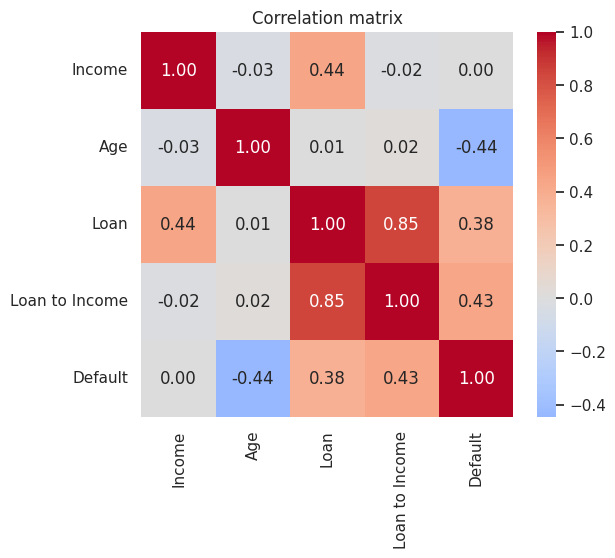

In [21]:
plt.figure(figsize=(6,5))
corr = df[num_cols + ['Default']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation matrix")
plt.show()

## 9 — Preprocessing & Train/Test Split
Save processed files and scaler for reproducibility.

In [22]:
# create output folders
os.makedirs("data/processed", exist_ok=True)
os.makedirs("models", exist_ok=True)

# features and target
target_col = "Default"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].copy()
y = df[target_col].copy()

# split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Shapes: ", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert back to DataFrame for saving/inspection
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

# save processed datasets and scaler
train_df = pd.concat([X_train_scaled.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test_scaled.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
train_df.to_csv("data/processed/train_processed.csv", index=False)
test_df.to_csv("data/processed/test_processed.csv", index=False)
joblib.dump(scaler, "models/scaler_standard.joblib")

print("Saved processed files and scaler.")

Shapes:  (1600, 4) (400, 4) (1600,) (400,)
Saved processed files and scaler.


## 10 — Train Models

In [23]:
# Prepare arrays for models
X_train_arr = X_train_scaled.values
X_test_arr  = X_test_scaled.values
y_train_arr = y_train.values
y_test_arr  = y_test.values

# Initialize models
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE)

# Fit models
lr.fit(X_train_arr, y_train_arr)
rf.fit(X_train_arr, y_train_arr)

print("Training complete.")

Training complete.


## 11 — Evaluate Models

In [24]:
models = {"LogisticRegression": lr, "RandomForest": rf}
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_arr)
    y_proba = model.predict_proba(X_test_arr)[:, 1]
    results[name] = {
        "accuracy": accuracy_score(y_test_arr, y_pred),
        "precision": precision_score(y_test_arr, y_pred, zero_division=0),
        "recall": recall_score(y_test_arr, y_pred, zero_division=0),
        "f1": f1_score(y_test_arr, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test_arr, y_proba),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "model": model
    }

# Print metrics
for name, r in results.items():
    print(f"--- {name} ---")
    print(f"Accuracy : {r['accuracy']:.4f}")
    print(f"Precision: {r['precision']:.4f}")
    print(f"Recall   : {r['recall']:.4f}")
    print(f"F1-score : {r['f1']:.4f}")
    print(f"ROC AUC  : {r['roc_auc']:.4f}")
    print(classification_report(y_test_arr, r['y_pred'], zero_division=0))
    print()

--- LogisticRegression ---
Accuracy : 0.9375
Precision: 0.7051
Recall   : 0.9649
F1-score : 0.8148
ROC AUC  : 0.9873
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       343
           1       0.71      0.96      0.81        57

    accuracy                           0.94       400
   macro avg       0.85      0.95      0.89       400
weighted avg       0.95      0.94      0.94       400


--- RandomForest ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC AUC  : 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00        57

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400




## 12 — Confusion Matrices & ROC Curves

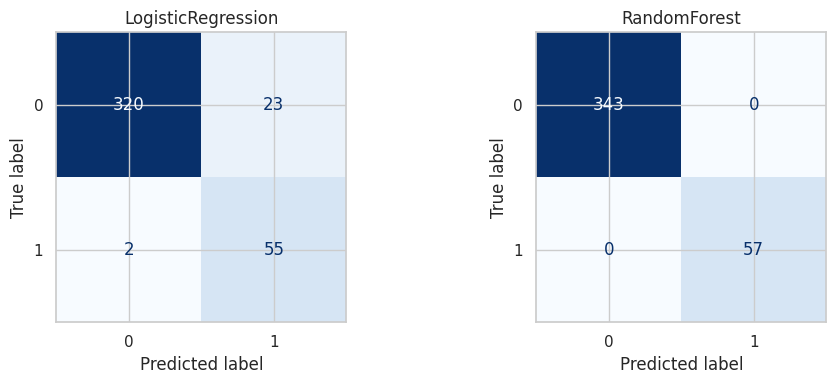

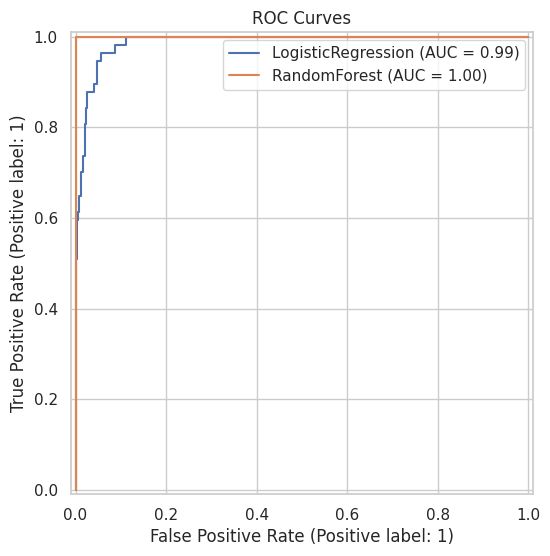

In [25]:
# Confusion matrices
plt.figure(figsize=(10,4))
for i, (name, r) in enumerate(results.items(), 1):
    plt.subplot(1, len(results), i)
    cm = confusion_matrix(y_test_arr, r['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(values_format='d', ax=plt.gca(), cmap='Blues', colorbar=False)
    plt.title(name)
plt.tight_layout()
plt.show()

# ROC curves
plt.figure(figsize=(8,6))
for name, r in results.items():
    RocCurveDisplay.from_predictions(y_test_arr, r['y_proba'], name=name, ax=plt.gca())
plt.title("ROC Curves")
plt.legend()
plt.show()

## 13 — Save Models & Best Model

In [26]:
# Save all models and save best by ROC AUC
best_name, best_auc = None, -1
for name, r in results.items():
    joblib.dump(r['model'], f"models/{name.lower()}.joblib")
    if r['roc_auc'] > best_auc:
        best_auc = r['roc_auc']
        best_name = name

joblib.dump(results[best_name]['model'], "models/best_model.joblib")
print(f"Saved models. Best model = {best_name} (ROC AUC = {best_auc:.4f})")

Saved models. Best model = RandomForest (ROC AUC = 1.0000)


## 14 — Inference Example

In [27]:
# How to load scaler + best model and run inference on new samples
scaler = joblib.load("models/scaler_standard.joblib")
best_model = joblib.load("models/best_model.joblib")

# Example: single new sample (replace with real values)
sample = {
    "Income": 50000,
    "Age": 35,
    "Loan": 4000,
    "Loan to Income": 0.08
}
sample_df = pd.DataFrame([sample])
sample_scaled = scaler.transform(sample_df)
pred_proba = best_model.predict_proba(sample_scaled)[:, 1][0]
pred_label = best_model.predict(sample_scaled)[0]

print("Predicted probability of default:", pred_proba)
print("Predicted label (0=no default, 1=default):", pred_label)

Predicted probability of default: 0.0
Predicted label (0=no default, 1=default): 0


## 15 — Conclusion & Next Steps
- Random Forest (or best model) selected based on ROC AUC.
- Next steps: hyperparameter tuning (GridSearch/RandomizedSearch), model explainability (SHAP), deploy with a simple API or dashboard.

### Files included in this submission
- `credit_card_default_final.ipynb` (this notebook)
- `data/processed/train_processed.csv`, `data/processed/test_processed.csv`
- `models/best_model.joblib`, `models/logisticregression.joblib`, `models/randomforest.joblib`
- `models/scaler_standard.joblib`